In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

import seaborn as sns
import os
import sys
import pickle
from glob import glob

from gryffin import Gryffin

sys.path.append('../../benchmarks_unknown/')
from benchmark_functions import DejongConstr

sns.set(style='ticks', context='notebook', font_scale=1.2)

In [2]:
# Golem colormap
_reference_colors = ['#008080', '#70a494', '#b4c8a8', '#f6edbd', '#edbb8a', '#de8a5a','#ca562c']
_cmap = LinearSegmentedColormap.from_list('golem', _reference_colors)
_cmap_r = LinearSegmentedColormap.from_list('golem_r', _reference_colors[::-1])
plt.register_cmap(cmap=_cmap)
plt.register_cmap(cmap=_cmap_r)

def get_golem_colors(n):
    _cmap = plt.get_cmap('golem')
    return [_cmap(x) for x in np.linspace(0, 1, n)]

def plot_contour(ax, X0, X1, y, xlims, ylims, vlims=[None, None], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_color='k', contour_alpha=1, cbar=False, cmap='golem'):
    # background surface
    if contour_lines is True:
        contours = ax.contour(X0, X1, y, n_contour_lines, colors=contour_color, alpha=contour_alpha, linestyles='dashed')
        if contour_labels is True:
            _ = ax.clabel(contours, inline=True, fontsize=labels_fs, fmt=labels_fmt)
    mappable = ax.imshow(y, extent=[xlims[0],xlims[1],ylims[0],ylims[1]], 
                         origin='lower', cmap=cmap, alpha=alpha, vmin=vlims[0], vmax=vlims[1])
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.5)
        
    return mappable

def plot_constr_surface(surface, ax=None, N=100):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    x0 = np.linspace(0,1,N)
    x1 = np.linspace(0,1,N)
    X0, X1 = np.meshgrid(x0,x1)
    X = np.array([X0.flatten(), X1.flatten()]).T
    y = np.array(surface.run(X)).flatten()
    Y = np.reshape(y, newshape=np.shape(X0))

    _ = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=1, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_alpha=0.8, cbar=False, cmap='golem')
    for param in surface.minima:
        x_min = param['params']
        ax.scatter(x_min[0], x_min[1], s=200, marker='*', color='r', zorder=20)
    
    y_feas = np.array(surface.eval_constr(X))
    Y_feas = np.reshape(y_feas, newshape=np.shape(X0))
    ax.imshow(Y_feas, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.5, interpolation='none')

In [35]:
from olympus.surfaces import Dejong, HyperEllipsoid
from benchmark_functions import Constr

class DummySurface1(HyperEllipsoid, Constr):
    def is_feasible(self, Xi):
        if isinstance(Xi, dict):
            x0 = Xi['x0']
            x1 = Xi['x1']
        else:
            x0 = Xi[0]
            x1 = Xi[1]
        if x0 + x1 > 1.0:
            return False
        else:
            return True
        
        
class DummySurface2(HyperEllipsoid, Constr):
    def is_feasible(self, Xi):
        if isinstance(Xi, dict):
            x0 = Xi['x0']
            x1 = Xi['x1']
        else:
            x0 = Xi[0]
            x1 = Xi[1]
        
        if x0**2 + (x1-1)**2 < 0.25:
            return False
        if (x0-1)**2 + x1**2 < 0.25:
            return False
        return True
    
    
class DummySurface3(HyperEllipsoid, Constr):
    def is_feasible(self, Xi):
        if isinstance(Xi, dict):
            x0 = Xi['x0']
            x1 = Xi['x1']
        else:
            x0 = Xi[0]
            x1 = Xi[1]
        Xi = np.array([x0, x1])
        
        if np.sum(np.sqrt(np.abs(Xi-0.5))) < 0.70:
            return False
        return True
    

class DummySurface4(HyperEllipsoid, Constr):
    def is_feasible(self, Xi):
        if isinstance(Xi, dict):
            x0 = Xi['x0']
            x1 = Xi['x1']
        else:
            x0 = Xi[0]
            x1 = Xi[1]
        Xi = np.array([x0, x1])
        
        centers = [[0.25, 0.25],[0.25, 0.75],[0.5, 0.5], [0.75, 0.25],[0.75, 0.75]]
        
        for center in centers:
            if (x0 - center[0])**2 + (x1 - center[1])**2 < 0.015:
                return False
        return True

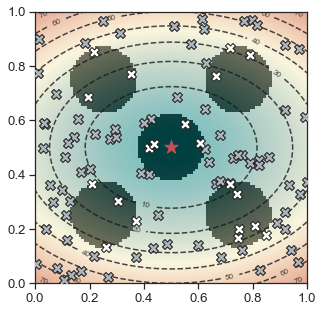

In [40]:
surface = DummySurface4()
n = 100

# random sampling
np.random.seed(15)
X = np.random.uniform(low=0, high=1, size=(n, 2))
obj = np.array(surface.run_constr(X)).flatten()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plot_constr_surface(surface, ax=ax, N=100)

mask = np.isnan(obj)
X_feas = X[~mask]
X_infs = X[mask]

ax.scatter(X[~mask].T[0], X[~mask].T[1], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
ax.scatter(X[mask].T[0], X[mask].T[1], marker='X', s=100, color='white', edgecolor='k', zorder=10)

In [29]:
config = {
     "general": {
             "batches": 1,
             "parallel": False,
             "boosted":  False,
             "scratch_dir": './scratch',
             "sampling_strategies": 1,
             "random_seed":42,
             "feas_approach": "fwa", 
             "feas_sensitivity": 1,
             "acquisition_optimizer": "genetic"
                },
    "model": {'num_epochs':  2 * 10**3,
              'learning_rate': 0.05,
              },
    "parameters": [
        {"name": "x0", "type": "continuous", "low": 0., "high": 1.},
        {"name": "x1", "type": "continuous", "low": 0., "high": 1.}
    ],
    "objectives": [
        {"name": "obj", "goal": "min"}
    ]
}

surface = DummySurface2()
gryffin = Gryffin(config_dict=config, known_constraints=surface.is_feasible)

In [30]:
from IPython.display import clear_output    

observations = []
sampling_strategies = np.array([1, -1])

for num_iter in range(3):
    print('ITERATION: ', num_iter+1)
    
    select_idx = num_iter % len(sampling_strategies)
    sampling_strategy = sampling_strategies[select_idx]
    
    # query for new parameters
    params = gryffin.recommend(observations=observations, sampling_strategies=[sampling_strategy])
    param = params[0]
    
    # evaluate the proposed parameters
    observation = surface.eval_merit(param)
    observations.append(observation)

    # clear cell
    clear_output(wait=True)

ITERATION:  3
[INFO] BayesianNetwork ... training a BNN to build the surrogate model ...
[INFO] BayesianNetwork ... [TIME]:  2.44 s  (overall) ...
[INFO] Acquisition ... [TIME]:  43.1678 ms  (random proposals) ...
[INFO] Acquisition ... running serial optimization for lambda strategy number 0 ...
[INFO] Acquisition ... [TIME]:  700.5491 ms  (optimizing proposals) ...
[INFO] Acquisition ... [TIME]:  744.2482 ms  (overall) ...
[INFO] SampleSelector ... running serial process for lambda strategy number 0 ...
[INFO] SampleSelector ... [TIME]:  265.3189 ms  (selecting proposals) ...
[INFO] Gryffin ... [MEM]:  0.0 GB, 393.0 MB, 961.0 kB ...
[INFO] Gryffin ... [TIME]:  3.46 s  (overall) ...


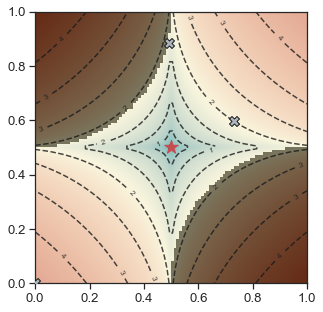

In [31]:
X_samples = np.array([[o['x0'], o['x1']] for o in observations])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plot_constr_surface(surface, ax=ax, N=100)

ax.scatter(X_samples.T[0], X_samples.T[1], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)